In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, utils, datasets
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [11]:
# 1. Load CIFAR-10 dataset
NUM_CLASSES = 10
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [12]:
# 2. Preprocess Data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

In [13]:
# 3. Build the Model
input_layer = layers.Input(shape=(32, 32, 3))

# Resize 32x32 images to 128x128 because MobileNetV2 expects bigger input
resize_layer = layers.Resizing(128, 128)(input_layer)

# Load MobileNetV2 base model
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=resize_layer,
    pooling="avg"   # GlobalAveragePooling2D
)

# Freeze the base model (initial training)
base_model.trainable = False

# Add custom head
x = base_model.output
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs=input_layer, outputs=output_layer)

<ipython-input-13-5afff0ead339>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [14]:
# 4. Compile the model
opt = optimizers.Adam(learning_rate=0.001)
model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_2          │ (None, 128, 128,  │          0 │ input_layer_4[0]… │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ resizing_2[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
# 5. Callbacks
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

In [16]:
# 6. Train the model (initial phase)
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=30,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accuracy: 0.6463 - loss: 1.0603 - val_accuracy: 0.7862 - val_loss: 0.6152 - learning_rate: 0.0010
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.7702 - loss: 0.6624 - val_accuracy: 0.7967 - val_loss: 0.5828 - learning_rate: 0.0010
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.7925 - loss: 0.6037 - val_accuracy: 0.8065 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8048 - loss: 0.5634 - val_accuracy: 0.8050 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8133 - loss: 0.5314 - val_accuracy: 0.8066 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.8197 - loss: 0.5087 - val_accuracy: 0.8080 - val_loss: 0.5593 - learning_rate: 0.0010
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8289 - l

In [17]:
# 7. Fine-tune: unfreeze the base model
base_model.trainable = True
for layer in base_model.layers[:50]:   # Freeze first 50 layers still
    layer.trainable = False

# Recompile for fine-tuning
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

In [18]:
# 8. Fine-tuning phase
history_finetune = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=15,
    validation_data=(x_test, y_test),
    shuffle=True,
    callbacks=[early_stop, reduce_lr],
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.6552 - loss: 1.6302 - val_accuracy: 0.8198 - val_loss: 0.6282 - learning_rate: 1.0000e-05
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.7856 - loss: 0.6678 - val_accuracy: 0.8263 - val_loss: 0.5782 - learning_rate: 1.0000e-05
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8357 - loss: 0.4924 - val_accuracy: 0.8380 - val_loss: 0.5214 - learning_rate: 1.0000e-05
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 43ms/step - accuracy: 0.8669 - loss: 0.3894 - val_accuracy: 0.8486 - val_loss: 0.4805 - learning_rate: 1.0000e-05
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.8946 - loss: 0.3091 - val_accuracy: 0.8589 - val_loss: 0.4600 - learning_rate: 1.0000e-05
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.9135 - loss: 0.2467 - val_accuracy: 0.8625 - val_loss: 0.4537 - learning_rate: 1.0000e-05
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/ste

In [19]:

# 9. Evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, batch_size=1000)
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1000)

print(f"Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}, Testing Loss: {test_loss:.4f}")



50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 213ms/step - accuracy: 0.9743 - loss: 0.0697
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 213ms/step - accuracy: 0.8809 - loss: 0.5264
Training Accuracy: 0.9730, Training Loss: 0.0730
Testing Accuracy: 0.8796, Testing Loss: 0.5287


In [20]:
# 10. Make Predictions
CLASSES = np.array(
    [
        "airplane", "automobile", "bird", "cat", "deer",
        "dog", "frog", "horse", "ship", "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step


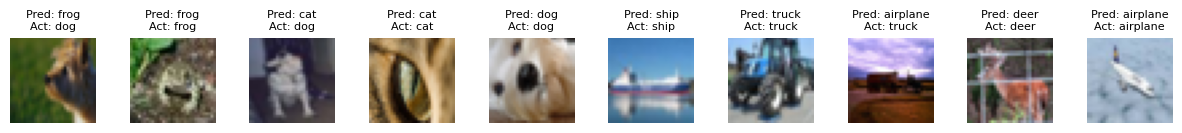

In [21]:
# 11. Display Predictions
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.set_title(f"Pred: {preds_single[idx]}\nAct: {actual_single[idx]}", fontsize=8)
    ax.imshow(img)

plt.show()